In [1]:
import logging
import sys
from pathlib import Path


logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s: %(message)s",
    force=True,
)

# Add the src directory to the Python path
sys.path.append(str(Path.cwd().parent.parent))

In [2]:
from src.nas.mlp_chromosome import RawMLPChromosome


low, high = RawMLPChromosome.get_bounds()
low, high

(array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([7, 3, 8, 7, 8, 7, 8, 7, 2, 3, 3, 1, 1, 6, 3]))

In [3]:
from src.nas.mlp_nas_problem import MlpNasProblem
from src.nas.nas import NasParams
from src.datasets.vertebral_dataset import VertebralDataset
from src.datasets.breast_cancer_dataset import BreastCancerDataset
from src.nas.plot import hist_accuracies


DatasetClass = VertebralDataset
params = NasParams(
    epochs=10,
    patience=5,
    amount_of_evaluations=1,
    population_size=10,
    population_offspring_count=4,
    algorithm_generations=1,
    # population_store_file=DatasetClass.__name__ + "_population.csv",
)
problem = MlpNasProblem(params, DatasetClass)

problem.get_min_complexity(), problem.get_max_complexity()

INFO: Loading cached vertebral from /home/nur/Projects/vut-ip1-nn-quantization/datasets_cache/vertebral_cache.pkl
INFO: Loading cached breast_cancer from /home/nur/Projects/vut-ip1-nn-quantization/datasets_cache/breast_cancer_cache.pkl


(162.0, np.float64(2160.0))

In [4]:
plow = problem.get_nn_params(RawMLPChromosome(low).parse())
phigh = problem.get_nn_params(RawMLPChromosome(high).parse())

problem.compute_nn_complexity(plow), problem.compute_nn_complexity(phigh)

(162.0, np.float64(2160.0))

In [5]:
from pymoo.optimize import minimize

from src.constants import SEED


algorithm = params.get_algorithm()
termination = params.get_termination()

res = minimize(problem, algorithm, verbose=True, seed=SEED, termination=termination)

if params.population_store_file is not None:
    params.store_population(res, params.population_store_file)

print(f"Solutions: {res.X}")
print(f"Objectives: {res.F}")

INFO: No population file provided. Using random sampling


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       10 |      3 |             - |             -
Solutions: [[4 0 3 7 2 0 4 4 1 0 3 0 0 5 3]
 [7 1 4 1 8 5 6 4 2 1 3 0 1 5 1]
 [0 0 7 6 1 0 1 2 2 0 0 1 0 4 2]]
Objectives: [[-0.70967742  0.10718336  0.03571429]
 [-0.58064516  0.07027027  0.21428571]
 [-0.29032258  0.          0.        ]]


In [6]:
df = problem.result_as_df(res)
df

,Accuracy,Complexity,fc,train,Chromosome
0,70.967742,376.152351,"{'layers': [{'height': 6, 'weight_qmode': Weig...","{'train_loader': ([tensor([[ 63.7724, 12.7634...","[4, 0, 3, 7, 2, 0, 4, 4, 1, 0, 3, 0, 0, 5, 3]"
1,58.064516,302.400000,"{'layers': [{'height': 6, 'weight_qmode': Weig...","{'train_loader': ([tensor([[ 54.9194, 21.0623...","[7, 1, 4, 1, 8, 5, 6, 4, 2, 1, 3, 0, 1, 5, 1]"
2,29.032258,162.000000,"{'layers': [{'height': 6, 'weight_qmode': Weig...","{'train_loader': ([tensor([[ 52.8622, 9.4104...","[0, 0, 7, 6, 1, 0, 1, 2, 2, 0, 0, 1, 0, 4, 2]"


In [7]:
from pprint import pprint

ch = RawMLPChromosome(df.loc[0]["Chromosome"]).parse()
params = problem.get_nn_params(ch)
pprint(params)

MLPParams(fc=FCParams(layers=[FCLayerParams(height=6,
                                            weight_qmode=<WeightQuantMode.NBITS: 'nbits'>,
                                            weight_bitwidth=5),
                              FCLayerParams(height=3,
                                            weight_qmode=<WeightQuantMode.NONE: 'none'>,
                                            weight_bitwidth=32)],
                      activation=ActivationParams(activation=<ActivationModule.RELU: 'relu'>,
                                                  binary_qmode=<QMode.DET: 'det'>,
                                                  reste_o=4.0,
                                                  reste_threshold=1.5),
                      qmode=<QMode.DET: 'det'>,
                      dropout_rate=0.1),
          train=NNTrainParams(train_loader=<torch.utils.data.dataloader.DataLoader object at 0x7acebd6552b0>,
                              test_loader=<torch.utils.data.dataloader.

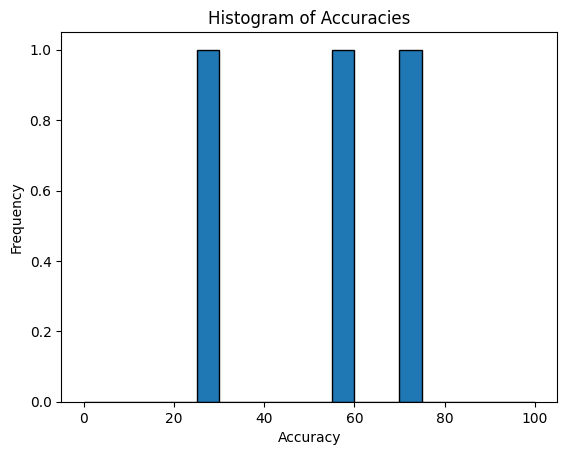

In [8]:
fig = hist_accuracies(df["Accuracy"])

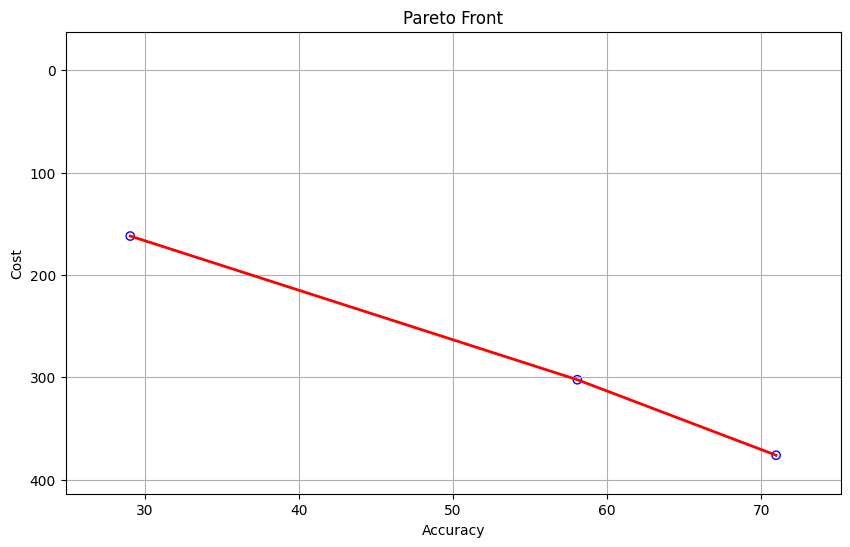

In [9]:
from src.nas import plot

plot.plot_pareto_front(df["Accuracy"], df["Complexity"])